## Configs and libraries to use

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score

%matplotlib inline
sns.set_style("whitegrid")


RND = 42
np.random.seed(RND)
torch.manual_seed(RND)


## Loading and inspecting data

In [3]:
df = pd.read_csv("1.csv")
print("Shape:", df.shape)
display(df.head())
display(df.dtypes.value_counts())
print("Missing values per column:")
print(df.isna().sum().sort_values(ascending=False).head())


Shape: (265500, 83)


,t_stamp,P1_STATE,LIT101.Pv,FIT101.Pv,MV101.Status,P101.Status,P102.Status,P2_STATE,FIT201.Pv,AIT201.Pv,...,FIT602.Pv,P601.Status,P602.Status,P603.Status,LSH601.Alarm,LSL601.Alarm,LSH602.Alarm,LSL602.Alarm,LSH603.Alarm,LSL603.Alarm
0,2024-04-23 09:15:00,1,548.8321,0.0,1,1,1,1,0.0,230.197388,...,1.017204,1,1,1,Inactive,Inactive,Active,Inactive,Inactive,Active
1,2024-04-23 09:15:01,1,548.8321,0.0,1,1,1,1,0.0,230.005127,...,1.005511,1,1,1,Inactive,Inactive,Active,Inactive,Inactive,Active
2,2024-04-23 09:15:02,1,548.8321,0.0,1,1,1,1,0.0,230.005127,...,1.005511,1,1,1,Inactive,Inactive,Active,Inactive,Inactive,Active
3,2024-04-23 09:15:03,1,548.8321,0.0,1,1,1,1,0.0,230.005127,...,1.013200,1,1,1,Inactive,Inactive,Active,Inactive,Inactive,Active
4,2024-04-23 09:15:04,1,548.8321,0.0,1,1,1,1,0.0,230.005127,...,1.009515,1,1,1,Inactive,Inactive,Active,Inactive,Inactive,Active


int64      41
float64    30
object     12
Name: count, dtype: int64

Missing values per column:
t_stamp         0
P1_STATE        0
LIT101.Pv       0
FIT101.Pv       0
MV101.Status    0
dtype: int64


## Cleaning

In [4]:
if "t_stamp" in df.columns:
    df = df.drop(columns=["t_stamp"])

obj_cols = df.select_dtypes(include="object").columns
alarm_cols = [c for c in obj_cols if set(df[c].unique()) <= {"Active","Inactive"}]
df[alarm_cols] = df[alarm_cols].apply(lambda s: s.map({"Active":1,"Inactive":0}))
numeric_cols = df.select_dtypes(include="number").columns.tolist()
print(f"Numeric features: {len(numeric_cols)}")


Numeric features: 82


## EDA

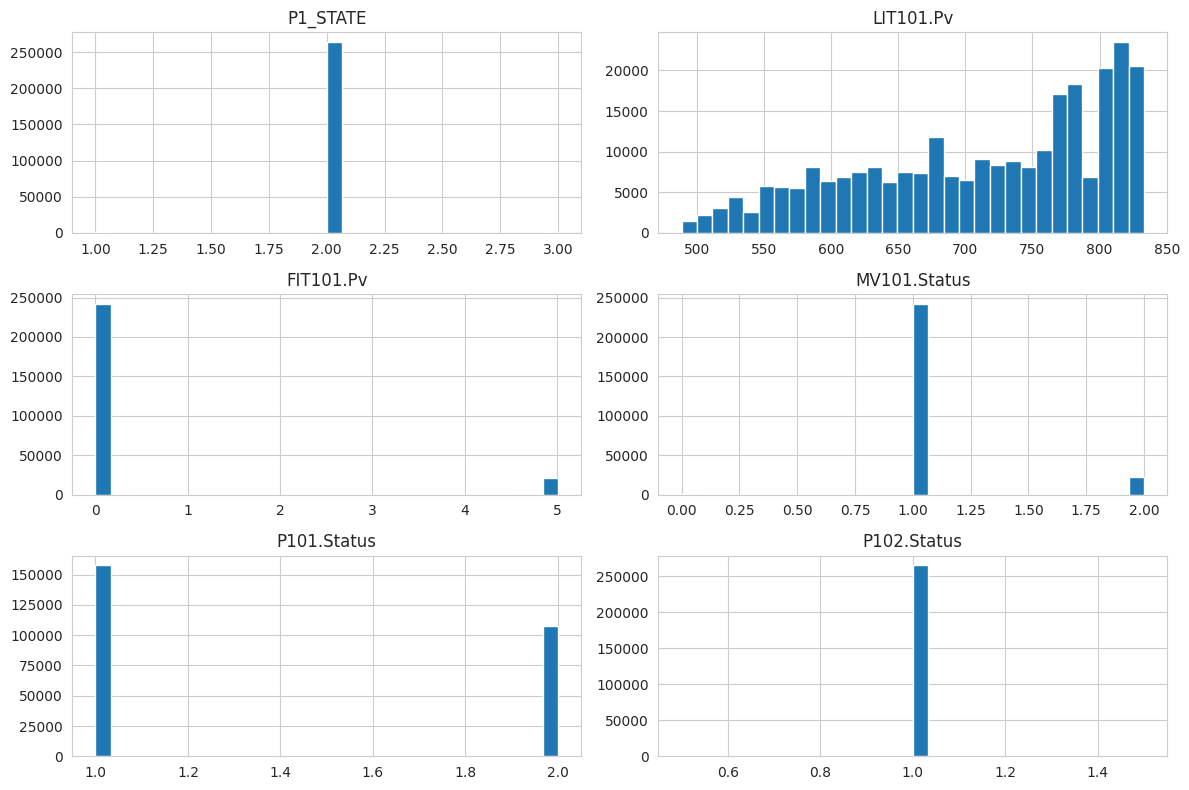

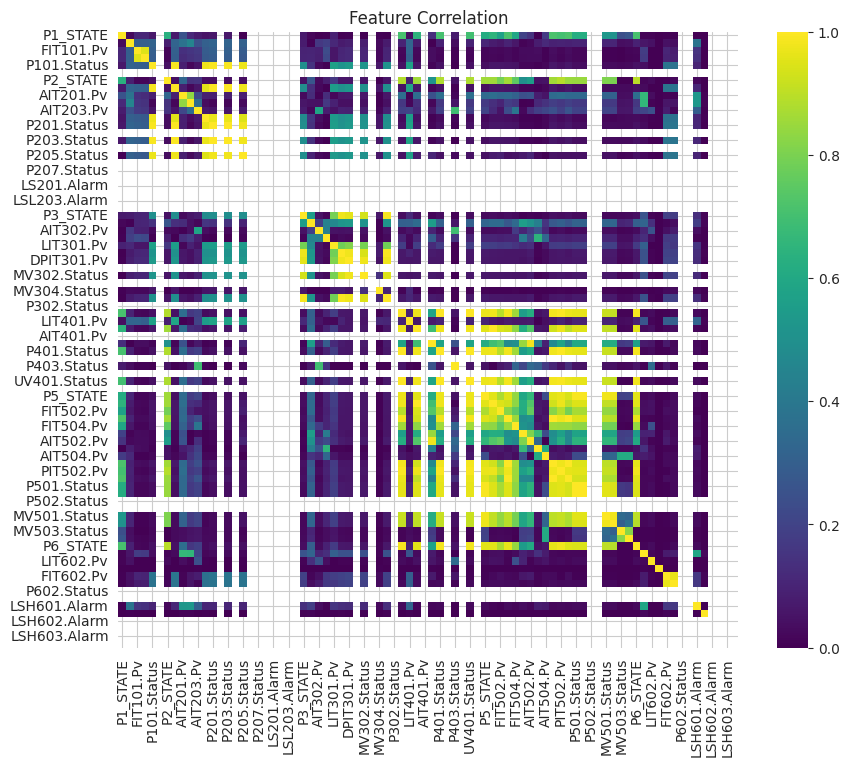

In [5]:

df[numeric_cols[:6]].hist(bins=30, figsize=(12,8))
plt.tight_layout()

corr = df[numeric_cols].corr().abs()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="viridis", vmin=0, vmax=1)
plt.title("Feature Correlation")
plt.show()


## PCA & Standardization

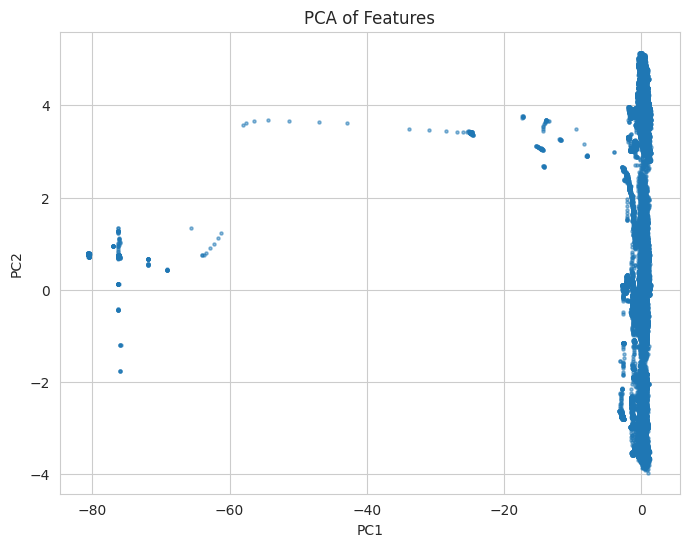

In [6]:

sc = StandardScaler()
X_num = sc.fit_transform(df[numeric_cols])

pca = PCA(n_components=2, random_state=RND)
proj = pca.fit_transform(X_num)

plt.figure(figsize=(8,6))
plt.scatter(proj[:,0], proj[:,1], s=5, alpha=0.5)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA of Features")
plt.show()


## KNN-Based Outlier Detection

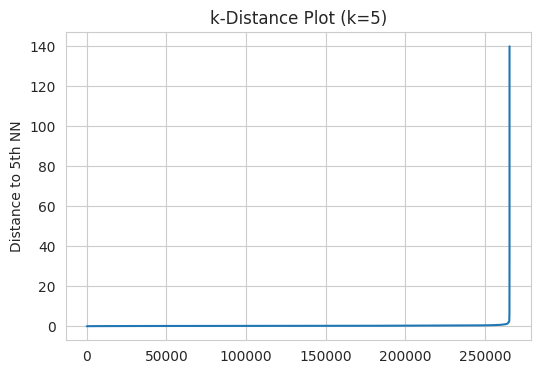

Anomalies detected: 13275


In [7]:

k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X_num)
dists, _ = nbrs.kneighbors(X_num)
k_dist = np.sort(dists[:, k-1])

plt.figure(figsize=(6,4))
plt.plot(k_dist)
plt.title(f"k-Distance Plot (k={k})")
plt.ylabel(f"Distance to {k}th NN")
plt.show()

lof = LocalOutlierFactor(n_neighbors=k, contamination=0.05)
y_lof = lof.fit_predict(X_num)
df['anomaly']   = (y_lof == -1).astype(int)
df['lof_score'] = lof.negative_outlier_factor_

print("Anomalies detected:", df['anomaly'].sum())


In [10]:

for col in alarm_cols:
    counts = df[col].value_counts()
    print(f"{col}:")
    print(counts)
    print("-" * 30)


LS201.Alarm:
LS201.Alarm
0    265500
Name: count, dtype: int64
------------------------------
LS202.Alarm:
LS202.Alarm
0    265500
Name: count, dtype: int64
------------------------------
LSL203.Alarm:
LSL203.Alarm
0    265500
Name: count, dtype: int64
------------------------------
LSLL203.Alarm:
LSLL203.Alarm
0    265500
Name: count, dtype: int64
------------------------------
LS401.Alarm:
LS401.Alarm
0    265500
Name: count, dtype: int64
------------------------------
LSH601.Alarm:
LSH601.Alarm
0    214284
1     51216
Name: count, dtype: int64
------------------------------
LSL601.Alarm:
LSL601.Alarm
0    265474
1        26
Name: count, dtype: int64
------------------------------
LSH602.Alarm:
LSH602.Alarm
1    265500
Name: count, dtype: int64
------------------------------
LSL602.Alarm:
LSL602.Alarm
0    265500
Name: count, dtype: int64
------------------------------
LSH603.Alarm:
LSH603.Alarm
0    265500
Name: count, dtype: int64
------------------------------
LSL603.Alarm:
LSL603

## Prepare for Classification

In [11]:

TARGET = "LSH601.Alarm"
print(df[TARGET].value_counts())


X = df[numeric_cols].values
y = df[TARGET].values


X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=RND, stratify=y
)



scaler = StandardScaler().fit(X_tr)
X_tr_s = scaler.transform(X_tr)
X_te_s = scaler.transform(X_te)

print("Training class distribution:", np.bincount(y_tr))
print("Test     class distribution:", np.bincount(y_te))


LSH601.Alarm
0    214284
1     51216
Name: count, dtype: int64
Training class distribution: [171427  40973]
Test     class distribution: [42857 10243]


## scikit-learn Classification: SVM, RF & Boosting

In [12]:
svm = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=RND)
svm.fit(X_tr_s, y_tr)
y_svm = svm.predict(X_te_s)
print("SVM Report:\n", classification_report(y_te, y_svm))




rf = RandomForestClassifier(n_estimators=100, random_state=RND)
rf.fit(X_tr, y_tr)
y_rf = rf.predict(X_te)
print("RF Report:\n", classification_report(y_te, y_rf))



gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=RND)
gbc.fit(X_tr, y_tr)
y_gbc = gbc.predict(X_te)
print("GBC Report:\n", classification_report(y_te, y_gbc))


SVM Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     42857
           1       1.00      1.00      1.00     10243

    accuracy                           1.00     53100
   macro avg       1.00      1.00      1.00     53100
weighted avg       1.00      1.00      1.00     53100

RF Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     42857
           1       1.00      1.00      1.00     10243

    accuracy                           1.00     53100
   macro avg       1.00      1.00      1.00     53100
weighted avg       1.00      1.00      1.00     53100

GBC Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     42857
           1       1.00      1.00      1.00     10243

    accuracy                           1.00     53100
   macro avg       1.00      1.00      1.00     53100
weighted avg       1.00      1.00   

## Torch FNN Classifier

In [13]:
X_tr_t = torch.tensor(X_tr_s, dtype=torch.float32)
y_tr_t = torch.tensor(y_tr, dtype=torch.long)
X_te_t = torch.tensor(X_te_s, dtype=torch.float32)
y_te_t = torch.tensor(y_te, dtype=torch.long)

train_ds = TensorDataset(X_tr_t, y_tr_t)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

class FNN(nn.Module):
    def __init__(self, inp, hidden, out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inp, hidden),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden//2, out)
        )
    def forward(self, x):
        return self.net(x)

model = FNN(X_tr_s.shape[1], 128, len(np.unique(y)))
opt = optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

for epoch in range(20):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = crit(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()

# evaluate
model.eval()
with torch.no_grad():
    preds = model(X_te_t).argmax(dim=1).numpy()
print("FNN Acc:", accuracy_score(y_te, preds))


FNN Acc: 1.0


## Torch LSTM Classifier

In [14]:

X_tr_l = X_tr_s.reshape(-1,1,X_tr_s.shape[1])
X_te_l = X_te_s.reshape(-1,1,X_te_s.shape[1])

X_tr_lt = torch.tensor(X_tr_l, dtype=torch.float32)
X_te_lt = torch.tensor(X_te_l, dtype=torch.float32)

train_l_ds = TensorDataset(X_tr_lt, y_tr_t)
train_l_dl = DataLoader(train_l_ds, batch_size=32, shuffle=True)

class LSTMCls(nn.Module):
    def __init__(self, feat, hid, out):
        super().__init__()
        self.lstm = nn.LSTM(feat, hid, batch_first=True)
        self.fc   = nn.Linear(hid, out)
    def forward(self, x):
        _, (h,_) = self.lstm(x)
        return self.fc(h.squeeze(0))

lstm = LSTMCls(X_tr_s.shape[1], 64, len(np.unique(y)))
opt2 = optim.Adam(lstm.parameters(), lr=1e-3)
crit2 = nn.CrossEntropyLoss()

for epoch in range(20):
    lstm.train()
    for xb, yb in train_l_dl:
        out = lstm(xb)
        loss = crit2(out, yb)
        opt2.zero_grad(); loss.backward(); opt2.step()

lstm.eval()
with torch.no_grad():
    preds_l = lstm(X_te_lt).argmax(dim=1).numpy()
print("LSTM Acc:", accuracy_score(y_te, preds_l))


LSTM Acc: 1.0


## Forecasting

In [15]:
series = df["LIT101.Pv"].values
ms = MinMaxScaler()
s_scaled = ms.fit_transform(series.reshape(-1,1)).flatten()


def windows(data, ws):
    Xw, yw = [], []
    for i in range(len(data)-ws):
        Xw.append(data[i:i+ws])
        yw.append(data[i+ws])
    return np.array(Xw), np.array(yw)

ws = 10
Xf, yf = windows(s_scaled, ws)
split = int(0.8*len(Xf))
Xf_tr, Xf_te = Xf[:split], Xf[split:]
yf_tr, yf_te = yf[:split], yf[split:]

Xf_tr = Xf_tr.reshape(-1, ws, 1)
Xf_te = Xf_te.reshape(-1, ws, 1)


## Torch GRU Forecasting & Boosting Regressor

In [16]:
Xf_tr_t = torch.tensor(Xf_tr, dtype=torch.float32)
yf_tr_t = torch.tensor(yf_tr, dtype=torch.float32).unsqueeze(-1)
Xf_te_t = torch.tensor(Xf_te, dtype=torch.float32)
yf_te_t = torch.tensor(yf_te, dtype=torch.float32).unsqueeze(-1)

class GRUFor(nn.Module):
    def __init__(self, inp, hid):
        super().__init__()
        self.gru = nn.GRU(inp, hid, batch_first=True)
        self.out = nn.Linear(hid, 1)
    def forward(self, x):
        _, h = self.gru(x)
        return self.out(h.squeeze(0))

gru = GRUFor(1, 50)
opt3 = optim.Adam(gru.parameters(), lr=1e-3)
crit3 = nn.MSELoss()


for epoch in range(20):
    gru.train()
    pred = gru(Xf_tr_t)
    loss = crit3(pred, yf_tr_t)
    opt3.zero_grad(); loss.backward(); opt3.step()


gru.eval()
with torch.no_grad():
    pred_gru = gru(Xf_te_t).numpy().flatten()
mse_gru = mean_squared_error(yf_te, pred_gru)
print(f"GRU MSE: {mse_gru:.4f}")


Xb_tr = Xf_tr.reshape(len(Xf_tr), -1)
Xb_te = Xf_te.reshape(len(Xf_te), -1)

gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=RND)
gbr.fit(Xb_tr, yf_tr)
pred_gbr = gbr.predict(Xb_te)
mse_gbr = mean_squared_error(yf_te, pred_gbr)
print(f"GBR MSE: {mse_gbr:.4f}, R2: {r2_score(yf_te, pred_gbr):.4f}")


GRU MSE: 0.0374
GBR MSE: 0.0000, R2: 0.9999


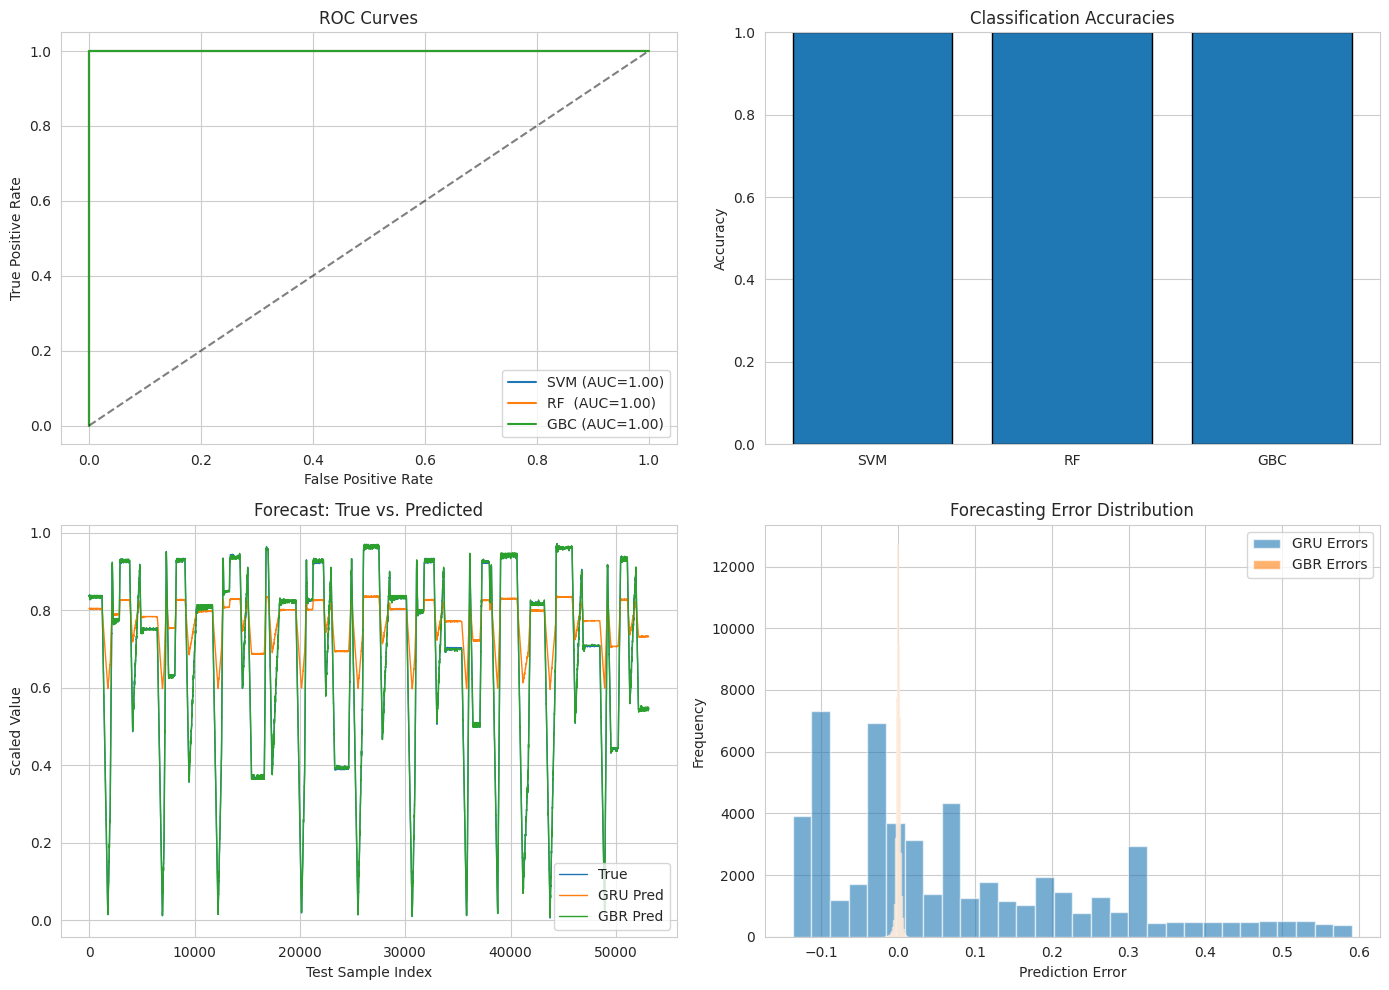

In [18]:
svm_scores = svm.decision_function(X_te_s)
fpr_svm, tpr_svm, _ = roc_curve(y_te, svm_scores)
auc_svm = auc(fpr_svm, tpr_svm)


rf_proba = rf.predict_proba(X_te)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_te, rf_proba)
auc_rf = auc(fpr_rf, tpr_rf)

gbc_proba = gbc.predict_proba(X_te)[:,1]
fpr_gbc, tpr_gbc, _ = roc_curve(y_te, gbc_proba)
auc_gbc = auc(fpr_gbc, tpr_gbc)


acc_svm = accuracy_score(y_te, svm.predict(X_te_s))
acc_rf  = accuracy_score(y_te, rf.predict(X_te))
acc_gbc = accuracy_score(y_te, gbc.predict(X_te))

fig, axes = plt.subplots(2, 2, figsize=(14,10))


ax = axes[0,0]
ax.plot(fpr_svm, tpr_svm, label=f"SVM (AUC={auc_svm:.2f})")
ax.plot(fpr_rf,  tpr_rf,  label=f"RF  (AUC={auc_rf:.2f})")
ax.plot(fpr_gbc, tpr_gbc, label=f"GBC (AUC={auc_gbc:.2f})")
ax.plot([0,1],[0,1],"k--", alpha=0.5)
ax.set_title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()


ax = axes[0,1]
methods = ["SVM","RF","GBC"]
accs    = [acc_svm, acc_rf, acc_gbc]
ax.bar(methods, accs, edgecolor="k")
ax.set_ylim(0,1)
ax.set_ylabel("Accuracy")
ax.set_title("Classification Accuracies")


ax = axes[1,0]
ax.plot(yf_te,      label="True", linewidth=1)
ax.plot(pred_gru,   label="GRU Pred", linewidth=1)
ax.plot(pred_gbr,   label="GBR Pred", linewidth=1)
ax.set_title("Forecast: True vs. Predicted")
ax.set_xlabel("Test Sample Index")
ax.set_ylabel("Scaled Value")
ax.legend()

ax = axes[1,1]
err_gru = pred_gru - yf_te
err_gbr = pred_gbr - yf_te
ax.hist(err_gru, bins=30, alpha=0.6, label="GRU Errors")
ax.hist(err_gbr, bins=30, alpha=0.6, label="GBR Errors")
ax.set_title("Forecasting Error Distribution")
ax.set_xlabel("Prediction Error")
ax.set_ylabel("Frequency")
ax.legend()

plt.tight_layout()
plt.show()
